# 실험 1
**공통**: 모듈 class화

**Dataset**: 클래스별 데이터 개수 균일화 및 얼굴부분에 대해서만 crop하는 Augmentation 구현

**Model**: ResNet18 base 모델에서 fc layer의 out_feature만 18로 수정

**Train**: scheduler로 fc 이전 레이어들과 fc 레이어의 learning rate를 조절, k-fold validation 적용, accumulation_steps 적용

**Experiment Tool**: wandb 적용

## base

### import

In [1]:
import os
import random
import collections
from glob import glob
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
from tqdm.notebook import tqdm
from time import time

from albumentations import *

import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split

from typing import Tuple

### 변수 선언

In [2]:
data_dir = '/opt/ml/input/data/train'

img_paths = glob(os.path.join(f'{data_dir}/images', '**/*'))
random.shuffle(img_paths)

## Dataset

### Augmentation
얼굴 부분만 가져오는 Augmentation 만들어보기

#### FaceCropWithDetection
cv2 face detection을 통해 얼굴 부분만 가져오기

In [3]:
class FaceCropWithDetection:
    '''
    image에서 detection을 이용해 얼굴 부분만 잘라주는 Augmentation
    '''
    def __init__(self, **args):
        pass
    
    def crop_image(self, image):
        '''
        input 
            image: PIL Image
        output
            tuple: (x, y, w, h)
        '''
        casc_path = "haarcascade_frontalface_default.xml"
        face_cascade = cv.CascadeClassifier(casc_path)
        
        frame_gray = cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
        frame_gray = cv.equalizeHist(frame_gray)
        
        # 얼굴 탐지
        faces = face_cascade.detectMultiScale(frame_gray)
        
        # 탐지된 얼굴이 없는 경우
        if len(faces) == 0:
            return 0, 0, 0, 0
        
        # 인식한 1번째 얼굴의 시작 x좌표, 시작 y좌표, 너비, 높이 리턴
        return faces[0]
    
    def __call__(self, image):
        '''
        input
            image: PIL Image
        output
            PIL Image
        '''
        # 얼굴 x, y, w, h 데이터 받기
        x, y, w, h = self.crop_image(image)
        out = np.array(image)
        
        # 탐지된 얼굴이 있는 경우
        if w != 0 or h != 0:
            out = out[y:y+h, x:x+w]
        
        # PIL Image로 리턴
        return Image.fromarray(out)

#### FaceCropWithHSV
rgb 데이터를 hsv로 변환한 후, 특정 범위의 값을 가지는 pixel들을 모두 포함하는 부분만 가져오기

In [4]:
class FaceCropWithHSV:
    '''
    image에서 hsv 데이터를 바탕으로 얼굴 부분만 잘라주는 Augmentation
    '''
    def __init__(self, **args):
        pass
    
    def get_face_box(self, image_path):
        '''
        input
            image_path: str(이미지 경로)
        output
            tuple: (y_start, y_end, x_start, x_end)
        '''
        # hsv 범위 설정
        lower = np.array([0, 48, 80], dtype = "uint8") # 0 48 80
        upper = np.array([30, 255, 255], dtype = "uint8") # 20 255 255
        
        image = cv.imread(image_path)
        hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
        skin_mask = cv.inRange(hsv_image, lower, upper)
        
        y_start, y_end = 1000, 0
        x_start, x_end = 1000, 0
        
        for y in range(len(skin_mask)):
            for x in range(len(skin_mask[0])):
                if skin_mask[y][x] > 0:
                    y_start, y_end = min(y_start, y), max(y_end, y)
                    x_start, x_end = min(x_start, x), max(x_end, x)
        return y_start, y_end, x_start, x_end
    
    def __call__(self, image_path):
        '''
        input
            image_path: str(이미지 경로)
        '''
        # 얼굴 x_start, y_start, x_end, y_end 데이터 받기
        y_start, y_end, x_start, x_end = self.get_face_box(image_path)
        
        # 이미지 경로를 ndarray로 변환
        image = Image.open(image_path)
        image = np.asarray(image)
        
        return Image.fromarray(image[y_start:y_end+1, x_start:x_end+1])

#### 테스트

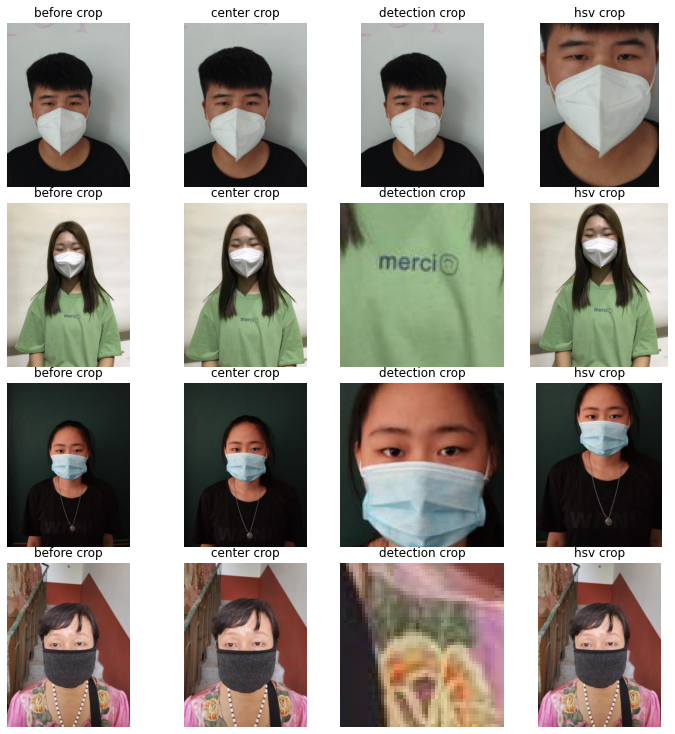

In [5]:
# 테스트할 이미지 파일 개수 설정
N = 4

# 사용할 이미지 파일을 랜덤하게 선택
idxs = np.random.choice(len(img_paths), N)
imgpath_list = np.array(img_paths)[idxs]

# CenterCrop에 사용할 crop_size 정의
portion = 0.9
crop_size = (int(512*portion), int(384*portion))

# transform 정의
centercrop = transforms.CenterCrop(crop_size)
detection_crop = FaceCropWithDetection()
hsv_crop = FaceCropWithHSV()

# 결과 시각화
fig, ax = plt.subplots(N, 4, figsize=(10, 10))

for idx, image_path in enumerate(imgpath_list):
    # 원본 이미지
    image = Image.open(image_path)
    
    # transform을 적용한 이미지들
    centercrop_image = centercrop(image)
    dection_image = detection_crop(image)
    hsv_image = hsv_crop(image_path)
    
    ax[idx][0].set_title('before crop')
    ax[idx][0].imshow(image)
    ax[idx][0].set_axis_off()
    
    ax[idx][1].set_title('center crop')
    ax[idx][1].imshow(centercrop_image)
    ax[idx][1].set_axis_off()
    
    ax[idx][2].set_title('detection crop')
    ax[idx][2].imshow(dection_image)
    ax[idx][2].set_axis_off()
    
    ax[idx][3].set_title('hsv crop')
    ax[idx][3].imshow(hsv_image)
    ax[idx][3].set_axis_off()

plt.tight_layout(0)
plt.show()